In [21]:
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import  TfidfVectorizer
from lightgbm import LGBMClassifier
import spacy

In [3]:
# Load the dataset
dataset = pd.read_csv(r'C:\Users\Deepu\OneDrive\Desktop\Capstone1\reddit_preprocessing.csv')

In [4]:
# Drop rows with NaN values in 'clean_comment'
cleaned_dataset = dataset.dropna()

# Separate features and target
X_cleaned = cleaned_dataset['clean_comment']
y_cleaned = cleaned_dataset['category']

In [6]:
# Split the cleaned data into train and test sets (80-20 split)
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=42
)

In [9]:
! python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 3.6 MB/s eta 0:00:04
     ----- ---------------------------------- 1.8/12.8 MB 3.7 MB/s eta 0:00:03
     -------- ------------------------------- 2.6/12.8 MB 3.7 MB/s eta 0:00:03
     ---------- ----------------------------- 3.4/12.8 MB 3.9 MB/s eta 0:00:03
     -------------- ------------------------- 4.7/12.8 MB 4.3 MB/s eta 0:00:02
     ------------------ --------------------- 5.8/12.8 MB 4.5 MB/s eta 0:00:02
     --------------------- ------------------ 6.8/12.8 MB 4.6 MB/s eta 0:00:02
     ------------------------- -------------- 8.1/12.8 MB 4.7 MB/s eta 0:00:01
     ---------------------------- ----------- 9.2/12.8 MB 4.8 MB/s eta 0:00:01
     -------------------------------- ------- 10.5/12.8 MB 4.9 MB/s eta 0:00:01
     ----------------------------------- ---- 11.3/12.8 MB 4.9 MB

In [10]:
# Load spacy language model for POS tagging
nlp = spacy.load("en_core_web_sm")

In [13]:
# Function to extract custom features
def extract_custom_features(text):
    doc = nlp(text)
    word_list = [token.text for token in doc]
    
    # 1. Comment Length (number of characters)
    comment_length = len(text)
    
    # 2. Word Count
    word_count = len(word_list)
    
    # 3. Average Word Length
    avg_word_length = sum(len(word) for word in word_list) / word_count if word_count > 0 else 0
    
    # 4. Unique Word Count
    unique_word_count = len(set(word_list))
    
    # 5. Lexical Diversity
    lexical_diversity = unique_word_count / word_count if word_count > 0 else 0
    
    # 6. Count of POS Tags
    pos_counts = {}
    for token in doc:
        pos = token.pos_
        pos_counts[pos] = pos_counts.get(pos, 0) + 1
    
    # 7. Sentiment scores (using spaCy's default sentiment analysis)
    # Note: You might want to use a dedicated sentiment analyzer for better results
    sentiment_score = 0
    
    # 8. Named Entity counts
    entity_counts = {}
    for ent in doc.ents:
        entity_type = ent.label_
        entity_counts[entity_type] = entity_counts.get(entity_type, 0) + 1
    
    # 9. Sentence Count
    sentence_count = len(list(doc.sents))
    
    # 10. Average Sentence Length (in words)
    avg_sent_length = word_count / sentence_count if sentence_count > 0 else 0
    
    # Create a dictionary with all features
    features = {
        'comment_length': comment_length,
        'word_count': word_count,
        'avg_word_length': avg_word_length,
        'unique_word_count': unique_word_count,
        'lexical_diversity': lexical_diversity,
        'sentence_count': sentence_count,
        'avg_sent_length': avg_sent_length
    }
    
    # Add POS tag counts to features
    for pos, count in pos_counts.items():
        features[f'pos_{pos}'] = count
    
    # Add entity counts to features
    for entity_type, count in entity_counts.items():
        features[f'entity_{entity_type}'] = count
    
    return features

In [14]:
# Apply the feature extraction function to our datasets
def extract_features_for_dataset(texts):
    features_list = []
    for text in texts:
        features = extract_custom_features(text)
        features_list.append(features)
    return pd.DataFrame(features_list)

# Extract features for train and test sets
X_train_features = extract_features_for_dataset(X_train_cleaned)
X_test_features = extract_features_for_dataset(X_test_cleaned)

# Display the shape and first few rows of the extracted features
print("Train features shape:", X_train_features.shape)
X_train_features.head()

Train features shape: (29400, 43)


,comment_length,word_count,avg_word_length,unique_word_count,lexical_diversity,sentence_count,avg_sent_length,pos_DET,pos_NOUN,pos_AUX,pos_VERB,pos_SCONJ,pos_ADJ,pos_PRON,pos_ADV,pos_PROPN,pos_ADP,pos_PART,pos_CCONJ,pos_INTJ,entity_GPE,entity_ORG,entity_NORP,entity_PRODUCT,entity_PERSON,pos_NUM,pos_SYM,entity_MONEY,entity_CARDINAL,entity_DATE,entity_LOC,pos_X,pos_PUNCT,entity_TIME,entity_ORDINAL,pos_SPACE,entity_LANGUAGE,entity_QUANTITY,entity_FAC,entity_PERCENT,entity_EVENT,entity_LAW,entity_WORK_OF_ART
0,107,17,5.352941,15,0.882353,1,17.0,1.0,5.0,2.0,3.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19,2,9.000000,2,1.000000,1,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,551,91,5.065934,75,0.824176,2,45.5,7.0,20.0,6.0,16.0,3.0,11.0,5.0,8.0,6.0,6.0,1.0,1.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,101,15,5.800000,15,1.000000,1,15.0,2.0,3.0,1.0,2.0,NaN,3.0,NaN,2.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,49,8,5.250000,8,1.000000,1,8.0,1.0,1.0,NaN,2.0,NaN,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
X_train_features.fillna(0,inplace=True)
X_test_features.fillna(0,inplace=True)

In [18]:
X_train_features.isnull().sum()


comment_length        0
word_count            0
avg_word_length       0
unique_word_count     0
lexical_diversity     0
sentence_count        0
avg_sent_length       0
pos_DET               0
pos_NOUN              0
pos_AUX               0
pos_VERB              0
pos_SCONJ             0
pos_ADJ               0
pos_PRON              0
pos_ADV               0
pos_PROPN             0
pos_ADP               0
pos_PART              0
pos_CCONJ             0
pos_INTJ              0
entity_GPE            0
entity_ORG            0
entity_NORP           0
entity_PRODUCT        0
entity_PERSON         0
pos_NUM               0
pos_SYM               0
entity_MONEY          0
entity_CARDINAL       0
entity_DATE           0
entity_LOC            0
pos_X                 0
pos_PUNCT             0
entity_TIME           0
entity_ORDINAL        0
pos_SPACE             0
entity_LANGUAGE       0
entity_QUANTITY       0
entity_FAC            0
entity_PERCENT        0
entity_EVENT          0
entity_LAW      

In [22]:
# Create the best model using tuned hyperparameters
best_model = LGBMClassifier(
    objective="multiclass",
    num_class=3,
    metric="multi_logloss",
    is_unbalance=True,
    class_weight="balanced",
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    learning_rate=0.09784602901436658,
    max_depth=17,
    n_estimators=482
)

In [23]:
# Apply TfidfVectorizer with trigram setting and max_features=10000
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train_cleaned)
X_test_tfidf = tfidf.transform(X_test_cleaned)

In [24]:
# Convert TF-IDF to DataFrame
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names_out())
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [25]:
# Combine TF-IDF and custom features
X_train_combined = pd.concat([X_train_tfidf_df.reset_index(drop=True), X_train_features.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([X_test_tfidf_df.reset_index(drop=True), X_test_features.reset_index(drop=True)], axis=1)

In [26]:
# Display the shape of the combined dataset
X_train_combined.shape, X_test_combined.shape

((29400, 10043), (7350, 10043))

In [27]:
X_train_combined

,000,100,1000,101,10th,120,150,16s,180ml,1947,1984,1st,200,2000,2002,2003,2004,2005,2007,2008,2009,2010,2011,2012,2013,2014,2014 and,2014 elections,2015,2016,2017,2018,2019,2019 elections,2020,2022,2024,250,2findia,2findia subject,...,unique_word_count,lexical_diversity,sentence_count,avg_sent_length,pos_DET,pos_NOUN,pos_AUX,pos_VERB,pos_SCONJ,pos_ADJ,pos_PRON,pos_ADV,pos_PROPN,pos_ADP,pos_PART,pos_CCONJ,pos_INTJ,entity_GPE,entity_ORG,entity_NORP,entity_PRODUCT,entity_PERSON,pos_NUM,pos_SYM,entity_MONEY,entity_CARDINAL,entity_DATE,entity_LOC,pos_X,pos_PUNCT,entity_TIME,entity_ORDINAL,pos_SPACE,entity_LANGUAGE,entity_QUANTITY,entity_FAC,entity_PERCENT,entity_EVENT,entity_LAW,entity_WORK_OF_ART
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15,0.882353,1,17.0,1.0,5.0,2.0,3.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,1.000000,1,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,75,0.824176,2,45.5,7.0,20.0,6.0,16.0,3.0,11.0,5.0,8.0,6.0,6.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15,1.000000,1,15.0,2.0,3.0,1.0,2.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,1.000000,1,8.0,1.0,1.0,0.0,2.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16,0.761905,1,21.0,5.0,5.0,0.0,5.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45,0.789474,1,57.0,2.0,18.0,5.0,12.0,0.0,4.0,5.0,4.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11,0.154930,1,71.0,0.0,14.0,0.0,7.0,1.0,14.0,14.0,7.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,47,0.783333,2,30.0,4.0,18.0,3.0,11.0,2.0,7.0,5.0,3.0,1.0,2.0,0.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [28]:
# Create the best model using tuned hyperparameters
best_model = LGBMClassifier(
    objective="multiclass",
    num_class=3,
    metric="multi_logloss",
    is_unbalance=True,
    class_weight="balanced",
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    learning_rate=0.09784602901436658,
    max_depth=17,
    n_estimators=482
)

In [29]:
# Train the model with combined features
best_model.fit(X_train_combined, y_train_cleaned)

# Predict on test set
y_pred = best_model.predict(X_test_combined)

# Evaluate model performance
from sklearn.metrics import classification_report, accuracy_score

# Print accuracy and classification report
print(f"Accuracy: {accuracy_score(y_test_cleaned, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test_cleaned, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 201397
[LightGBM] [Info] Number of data points in the train set: 29400, number of used features: 7156
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

In [30]:
# For comparison, train a model using only TF-IDF features
tfidf_only_model = LGBMClassifier(
    objective="multiclass",
    num_class=3,
    metric="multi_logloss",
    is_unbalance=True,
    class_weight="balanced",
    reg_alpha=0.1,
    reg_lambda=0.1,
    learning_rate=0.09784602901436658,
    max_depth=17,
    n_estimators=482
)

# Train on TF-IDF features only
tfidf_only_model.fit(X_train_tfidf_df, y_train_cleaned)

# Predict and evaluate
tfidf_only_pred = tfidf_only_model.predict(X_test_tfidf_df)
print("\n\nTF-IDF Only Model Performance:")
print(f"Accuracy: {accuracy_score(y_test_cleaned, tfidf_only_pred)}")
print("\nClassification Report:")
print(classification_report(y_test_cleaned, tfidf_only_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.189628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198917
[LightGBM] [Info] Number of data points in the train set: 29400, number of used features: 7117
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

In [31]:
# For comparison, train a model using only custom features
custom_only_model = LGBMClassifier(
    objective="multiclass",
    num_class=3,
    metric="multi_logloss",
    is_unbalance=True,
    class_weight="balanced",
    reg_alpha=0.1,
    reg_lambda=0.1,
    learning_rate=0.09784602901436658,
    max_depth=17,
    n_estimators=482
)

# Train on custom features only
custom_only_model.fit(X_train_features, y_train_cleaned)

# Predict and evaluate
custom_only_pred = custom_only_model.predict(X_test_features)
print("\n\nCustom Features Only Model Performance:")
print(f"Accuracy: {accuracy_score(y_test_cleaned, custom_only_pred)}")
print("\nClassification Report:")
print(classification_report(y_test_cleaned, custom_only_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 29400, number of used features: 39
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Custom Features Only Model Performance:
Accuracy: 0.5031292517006802

Classification Report:
              precision    recall  f1-score   support

          -1       0.27      0.30      0.29      1581
           0       0.60      0.69      0.64      2617
           1       0.55      0.45      0.49      3152

    accuracy                           0.50      7350
   macro avg       0.47      0.48      0.47      7350
weighted avg       0.51      0.50      0.50      7350

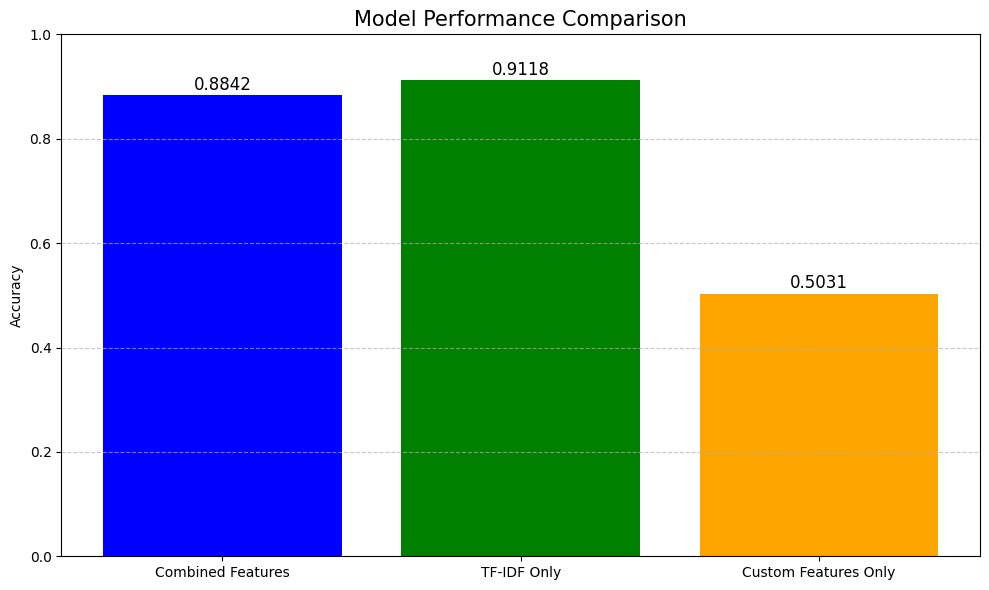

,Model,Accuracy
0,Combined Features,0.884218
1,TF-IDF Only,0.911837
2,Custom Features Only,0.503129


In [32]:
# Create a comparison dataframe of model performances
import matplotlib.pyplot as plt

# Collect accuracy scores
model_comparison = pd.DataFrame({
    'Model': ['Combined Features', 'TF-IDF Only', 'Custom Features Only'],
    'Accuracy': [
        accuracy_score(y_test_cleaned, y_pred),
        accuracy_score(y_test_cleaned, tfidf_only_pred),
        accuracy_score(y_test_cleaned, custom_only_pred)
    ]
})

# Plot the comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(model_comparison['Model'], model_comparison['Accuracy'], color=['blue', 'green', 'orange'])
plt.title('Model Performance Comparison', fontsize=15)
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# Display the comparison dataframe
model_comparison